In [1]:
%env CUDA_VISIBLE_DEVICES=0

import enum
import strenum
import sys
from typing import Callable, TypeAlias
import torch
import torch.nn as nn
import torch.nn.functional as F
from mishax import ast_patcher
from mishax import safe_greenlet
import numpy as np
import matplotlib.pyplot as plt
import odeformer

import scipy.integrate
import sympy as sp
import pickle
from pathlib import Path
import matplotlib.pyplot as plt

from tqdm import tqdm

env: CUDA_VISIBLE_DEVICES=0


In [4]:
from odeformer.model import SymbolicTransformerRegressor
from transformer import MultiHeadAttention, TransformerFFN

from odeformer.metrics import r2_score

In [11]:
class Site(strenum.StrEnum):
    """Instrumentation sites within an ODEFormer forward pass."""
    # Attention sites
    QUERY = enum.auto()
    KEY = enum.auto()
    VALUE = enum.auto()
    ATTN_SCORES = enum.auto()
    ATTN_PROBS = enum.auto()
    ATTN_OUTPUT = enum.auto()
    POST_ATTN_RESIDUAL = enum.auto()
    
    # Layer norm sites
    RESIDUAL = enum.auto()
    
    # Layer norm sites
    PRE_ATTN_LAYERNORM = enum.auto()
    PRE_MLP_LAYERNORM = enum.auto()

    # MLP sites
    MLP_INPUT = enum.auto()
    MLP_HIDDEN = enum.auto()
    MLP_OUTPUT = enum.auto()
    POST_MLP_RESIDUAL = enum.auto()

    # Cross attention (decoder only)
    CROSS_ATTN_SCORES = enum.auto()
    CROSS_ATTN_PROBS = enum.auto()
    CROSS_ATTN_OUTPUT = enum.auto()

class ModulePathMapper:
    """Maps modules to their full paths including component names."""
    def __init__(self, model):
        self.path_map = {}
        self.model = model

        # Get paths from transformer components
        if hasattr(model, 'model'):
            model = model.model
            if hasattr(model, 'encoder'):
                for name, module in model.encoder.named_modules():
                    if len(name)==0:
                        name = "transformer"
                    self.path_map[id(module)] = f"encoder.{name}"

            if hasattr(model, 'decoder'):
                for name, module in model.decoder.named_modules():
                    if len(name)==0:
                        name = "transformer"
                    self.path_map[id(module)] = f"decoder.{name}"

    def get_layer_path(self, module: nn.Module, accessing_component: str = None) -> str:
        """Gets the full hierarchical path including the accessed component."""
        base_path = self.path_map.get(id(module))
        if base_path is None:
            return None

        # If accessing a specific component, append it
        if accessing_component:
            return f"{base_path}.{accessing_component}"

        return base_path

    def get_accessing_component(self, module: nn.Module, attr_name: str) -> str:
        """Gets the name of the component being accessed."""
        if hasattr(module, attr_name):
            component = getattr(module, attr_name)
            if isinstance(component, nn.Linear):
                return attr_name
        return None

_path_mapper = None

def _tag(module: nn.Module, site: Site, value: torch.Tensor, accessing: str = None) -> torch.Tensor:
    """Tags a value at a particular site for instrumentation."""
    try:
        parent = safe_greenlet.getparent()
        if parent is None:
            return value

        # Get full path including component
        path = None
        if _path_mapper is not None:
            path = _path_mapper.get_layer_path(module, accessing)

        ret = parent.switch((site, value, path))
        return ret if ret is not None else value
    except Exception as e:
        print(f"Error in tag at {site}: {e}")
        return value

def collect_activations_during_fit(model, times, trajectories):
    """Collects activations during model.fit()."""
    global _path_mapper
    _path_mapper = ModulePathMapper(model)
    return collect_activations(lambda: model.fit(times, trajectories))

def view_layer_paths(activations):
    """Displays activations organized by full layer paths."""
    print("\nActivations by Layer Path:")
    print("-------------------------")

    # Group by model section and type
    sections = {
        'encoder': {
            'attention': [],
            'ffn': [],
            'residual': []
        },
        'decoder': {
            'attention': [],
            'ffn': [],
            'encoder_attn': [],
             'residual': []
        }
    }

    # Collect unique paths and sort them
    for site_data in activations.values():
        for path in site_data.keys():
            if path is None:
                continue

            # Determine section and type
            if 'encoder.' in path:
                if any(x in path for x in ['q_lin', 'k_lin', 'v_lin', 'out_lin']):
                    sections['encoder']['attention'].append(path)
                elif any(x in path for x in ['lin1', 'lin2']):
                    sections['encoder']['ffn'].append(path)
            elif 'decoder.' in path:
                if 'encoder_attn' in path:
                    sections['decoder']['encoder_attn'].append(path)
                elif any(x in path for x in ['q_lin', 'k_lin', 'v_lin', 'out_lin']):
                    sections['decoder']['attention'].append(path)
                elif any(x in path for x in ['lin1', 'lin2']):
                    sections['decoder']['ffn'].append(path)

    # Print organized by section
    for section in ['encoder', 'decoder']:
        print(f"\n{section.upper()}:")
        for component_type, paths in sections[section].items():
            if paths:
                print(f"\n  {component_type}:")
                for path in sorted(set(paths)):
                    # Find this path in activations
                    for site, site_data in activations.items():
                        if path in site_data:
                            print(f"    {path}:")
                            for shape, tensor in site_data[path].items():
                                print(f"      Shape {shape}: {tensor.shape[0]} activations")

def install():
    """Installs the patchers to instrument the model."""
    print("\nInstalling patches...")

    PREFIX = f"""from {__name__} import Site, _tag as tag"""


    patcher = ast_patcher.ModuleASTPatcher(
        odeformer.model.transformer,
        ast_patcher.PatchSettings(
            prefix=PREFIX,
            allow_num_matches_upto={}  # If need to allow multiple matches
        ),
        #MultiHeadAttention=[
        #    # Self-attention computation chain
        #    """        scores = torch.matmul(q, k.transpose(2, 3))  # (bs, n_heads, qlen, klen)""",
        #    """        scores = tag(self, Site.ATTN_SCORES, torch.matmul(q, k.transpose(2, 3)), accessing='scores')  # (bs, n_heads, qlen, klen)""",

        #    """        weights = F.softmax(scores.float(), dim=-1).type_as(scores)""",
        #    """        weights = tag(self, Site.ATTN_PROBS, F.softmax(scores.float(), dim=-1).type_as(scores), accessing='weights')""",

        #    """        context = torch.matmul(weights, v)""",
        #    """        context = tag(self, Site.ATTN_OUTPUT, torch.matmul(weights, v), accessing='context')"""
        # ],
        TransformerModel=[
         #   # LayerNorm and attention
            """            attn = self.attentions[i](tensor, attn_mask, use_cache=use_cache)""",
            """            attn = tag(self, Site.ATTN_OUTPUT, self.attentions[i](tag(self, Site.RESIDUAL,tensor, accessing="residual"+str(i)), attn_mask, use_cache=use_cache), accessing='attention_layer')""",
        ],
        TransformerFFN=[
            # Inside FFN
            """        x = self.lin1(input)""",
            """        x = self.lin1(tag(self, Site.MLP_INPUT, input, accessing='lin1_mlp_input'))""",

           # """        x = self.lin2(x)""",
           # """        x = tag(self, Site.MLP_OUTPUT, self.lin2(x), accessing='lin2_mlp_output')""",
        ]
    )

    try:
        patcher.install()
        print("\nPatches installed successfully")
    except Exception as e:
        print(f"\nError installing patches: {e}")
        import traceback
        traceback.print_exc()

    return patcher



def collect_activations(model_fn):
    """Collects activations during a model function execution."""
    print("\nStarting activation collection")
    activations = {}

    patcher = install()
    with patcher():
        def run_in_greenlet():
            try:
                print("Starting model execution in greenlet...")
                with torch.cuda.device(0):
                    result = model_fn()
                print("Model execution completed")
                return result
            except Exception as e:
                print(f"Error in greenlet execution: {e}")
                import traceback
                traceback.print_exc()
                raise

        glet = safe_greenlet.SafeGreenlet(run_in_greenlet)
        print(f"Created SafeGreenlet: {glet}")

        with glet:
            try:
                print("Starting greenlet...")
                result = glet.switch()
                print("Initial switch complete")

                while glet:
                    site, value, name = result

                    # Initialize storage for this site if needed
                    if site not in activations:
                        activations[site] = {}

                    # Store by name within each site
                    if name not in activations[site]:
                        activations[site][name] = []

                    if torch.is_tensor(value):
                        activations[site][name].append(value.detach().cpu())

                    try:
                        result = glet.switch(value)
                    except StopIteration:
                        break

            except Exception as e:
                print(f"Error in activation collection: {e}")
                import traceback
                traceback.print_exc()
                raise

    print(f"Collection complete. Found sites: {list(activations.keys())}")

    if activations:
        print("\nProcessing activations...")

        # Process activations into a more structured format
        processed_activations = {}
        for site, name_data in activations.items():
            processed_activations[site] = {}

            for name, tensor_list in name_data.items():
                # Group tensors by shape
                shape_groups = {}
                for tensor in tensor_list:
                    shape = tuple(tensor.shape)
                    if shape not in shape_groups:
                        shape_groups[shape] = []
                    shape_groups[shape].append(tensor)

                # Store processed data
                processed_activations[site][name] = {
                    shape: torch.stack(tensors)
                    for shape, tensors in shape_groups.items()
                }

            # Print information
            print(f"\n{site}:")
            for name in processed_activations[site]:
                print(f"  Name: {name}")
                for shape, tensor in processed_activations[site][name].items():
                    print(f"    Shape {shape}: {tensor.shape[0]} tensors")

    return processed_activations, result

In [12]:
# First install patches
install()


Installing patches...

Patches installed successfully


In [13]:
model = SymbolicTransformerRegressor(
    from_pretrained=True)

model_args = {'beam_size':20,
        'beam_temperature':0.1}
model.set_model_args(model_args)

Found pretrained model at odeformer.pt
Loaded pretrained model


In [14]:
with open('two_systems_solutions.pkl', 'rb') as f:
    solutions = pickle.load(f)
    print("Loaded Solutions:",len(solutions))

Loaded Solutions: 20000


In [17]:
#### TODO:
#### Run system on GPU

torch.cuda.device_count()
print(torch.cuda.memory_allocated())

359431680


In [16]:
from IPython.utils import io
import time
from joblib import Parallel, delayed

np.infty=np.inf
collected_values = []
model.model.cuda(0)
for solution in tqdm(solutions):
    with io.capture_output() as captured:
        fit_activations, _ = collect_activations_during_fit(model, solution['time_points'], solution['solution'])
        collected_values.append({
            'params': solution['params'],
            'equations': solution['equations'],
            'solution': solution['solution'],
            'time_points': solution['time_points'],
            'activations': fit_activations
        })

  0%|                                                                             | 16/20000 [00:58<20:17:08,  3.65s/it]


KeyboardInterrupt: 

In [ ]:
import sys
print(sys.getsizeof(collected_values))
print(len(collected_values))

In [ ]:
# filter only RESIDUAL
for value in collected_values:
    value['activations']=value['activations']['RESIDUAL']

In [ ]:
print(sys.getsizeof(collected_values))

In [ ]:
%%time
sys.getsizeof(collected_values[0]['activations'])

In [13]:
with open('odeformer_activations_residual_two_systems.pkl', 'wb') as f:
    pickle.dump(collected_values, f)

In [ ]:
with open('odeformer_activations.pkl', 'rb') as f:
    solutions = pickle.load(f)

In [64]:
str(outputs[0][0]).split('|')[0].strip()

'0.4878 * x_0 + -0.1872 * x_0 * x_1'

In [65]:
len(solutions)

100

In [196]:
trajectory_str = [str(x[0]) for x in trajectory]
activations_weights = np.random.rand(len(trajectory_str))

In [38]:
collected_values[20]['activations']['encoder.transformer.residual1'].keys()

dict_keys([(1, 127, 256)])

In [40]:
fit_activations['RESIDUAL']['decoder.transformer.residual5'].keys()

dict_keys([(1, 1, 512), (20, 1, 512)])

In [69]:
fit_activations['RESIDUAL']['encoder.transformer.residual'][(1,100,256)][0]

tensor([[[ 0.0306,  0.0166, -0.1482,  ...,  0.2345,  0.0069, -0.0071],
         [ 0.0368, -0.0309, -0.1037,  ...,  0.1305, -0.0427, -0.0176],
         [ 0.0004,  0.0274, -0.0583,  ...,  0.1994, -0.1109, -0.0093],
         ...,
         [ 0.0281, -0.0396, -0.0461,  ...,  0.2628, -0.0433,  0.0020],
         [ 0.0162,  0.0040, -0.2489,  ...,  0.1862, -0.1093, -0.0028],
         [ 0.0174,  0.0297, -0.2257,  ...,  0.2872, -0.1503, -0.0076]]])

In [ ]:
heatmap, xedges, yedges = np.histogram2d(x, y, bins=(np.linspace(0,length_track,length_track+1),1))
extent = [0, length_track+1, 0, 50]
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='jet',vmin=0,vmax=None)

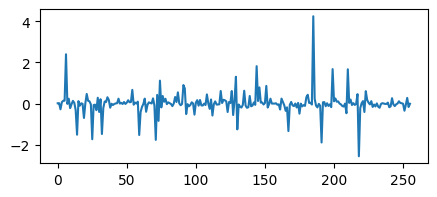

In [110]:
import matplotlib.pyplot as plt

x=fit_activations['RESIDUAL']['encoder.transformer.residual0'][(1,100,256)][0][0][0]
plt.plot(x)
plt.show()

In [114]:
fit_activations['RESIDUAL']['decoder.transformer.residual0'].keys()

dict_keys([(1, 1, 512), (20, 1, 512)])

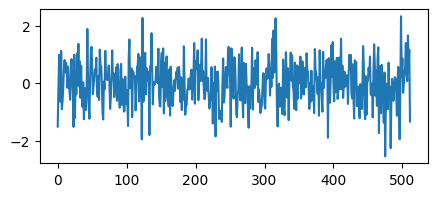

In [121]:
import matplotlib.pyplot as plt

x=fit_activations['RESIDUAL']['decoder.transformer.residual0'][(20,1,512)][5][0][0]
plt.plot(x)
plt.show()

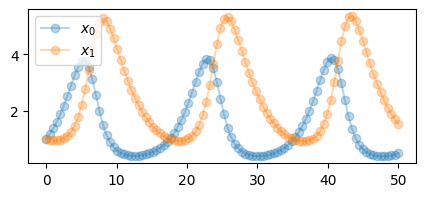

In [107]:
pred_traj = model.predict(times, trajectory[0])
dimension = len(trajectory[0])
for dim in range(dimension):
    plt.plot(times, trajectory[:, dim], color = f'C{dim}', label=f'$x_{dim}$', marker='o', alpha=.3)
    #plt.plot(times, pred_traj[:, dim],  color = f'C{dim}', label=f'$x_{dim}$ predicted')
plt.legend()

In [220]:
len(pred_traj)

100

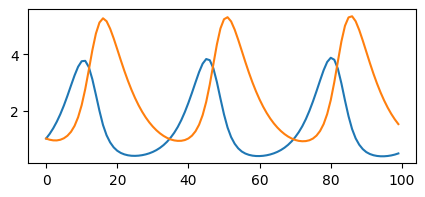

In [108]:
plt.plot(trajectory)

In [303]:
print(model.model.encoder.id2word)
print(model.model.decoder.id2word)

{0: '<EOS>', 1: '<X>', 2: '</X>', 3: '<Y>', 4: '</Y>', 5: '</POINTS>', 6: '<INPUT_PAD>', 7: '<OUTPUT_PAD>', 8: '<MASK>', 9: '<PAD>', 10: '(', 11: ')', 12: 'SPECIAL', 13: 'OOD_unary_op', 14: 'OOD_binary_op', 15: 'OOD_constant', 16: '+', 17: '-', 18: 'E-1', 19: 'E-10', 20: 'E-100', 21: 'E-11', 22: 'E-12', 23: 'E-13', 24: 'E-14', 25: 'E-15', 26: 'E-16', 27: 'E-17', 28: 'E-18', 29: 'E-19', 30: 'E-2', 31: 'E-20', 32: 'E-21', 33: 'E-22', 34: 'E-23', 35: 'E-24', 36: 'E-25', 37: 'E-26', 38: 'E-27', 39: 'E-28', 40: 'E-29', 41: 'E-3', 42: 'E-30', 43: 'E-31', 44: 'E-32', 45: 'E-33', 46: 'E-34', 47: 'E-35', 48: 'E-36', 49: 'E-37', 50: 'E-38', 51: 'E-39', 52: 'E-4', 53: 'E-40', 54: 'E-41', 55: 'E-42', 56: 'E-43', 57: 'E-44', 58: 'E-45', 59: 'E-46', 60: 'E-47', 61: 'E-48', 62: 'E-49', 63: 'E-5', 64: 'E-50', 65: 'E-51', 66: 'E-52', 67: 'E-53', 68: 'E-54', 69: 'E-55', 70: 'E-56', 71: 'E-57', 72: 'E-58', 73: 'E-59', 74: 'E-6', 75: 'E-60', 76: 'E-61', 77: 'E-62', 78: 'E-63', 79: 'E-64', 80: 'E-65', 81: 